# Modeling with Clustered Data

In [1]:
import preprocessing
import wrangle
import model

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score


# ignore warnings
import warnings
warnings.simplefilter(action='ignore')

import os.path
from os import path

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import re

from preprocessing_permits import permits_preprocessing_mother_function

import preprocessing_permits as pr

# Clustering

In [2]:
df = permits_preprocessing_mother_function()

In [3]:
df, kmeans, centroids, scaler, scaled_ei_threshold_value, x = pr.create_clusters(df)
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")

Our DataFrame contains 2,860 observations and 22 features.


In [4]:
import explore as ex

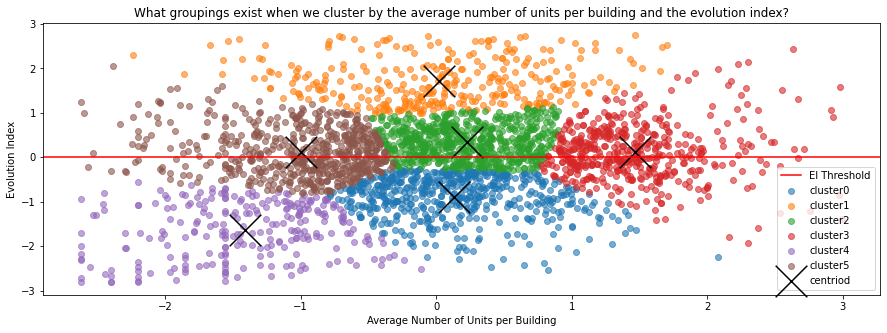

In [5]:
plt.figure(figsize=(15,5))
ex.visualize_clusters(df, centroids, scaled_ei_threshold_value)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2860 entries, 1 to 2989
Data columns (total 22 columns):
city                                       2860 non-null object
state                                      2860 non-null object
year                                       2860 non-null int64
total_high_density_bldgs                   2860 non-null float64
total_high_density_units                   2860 non-null float64
total_high_density_value                   2860 non-null float64
avg_units_per_bldg                         2860 non-null float64
value_per_bldg                             2860 non-null float64
value_per_unit                             2860 non-null float64
city_state_high_density_bldgs_delta_pct    2860 non-null float64
city_state_high_density_units_delta_pct    2860 non-null float64
city_state_high_density_value_delta_pct    2860 non-null float64
market_volume                              2860 non-null float64
market_volume_delta_pct                    2860 non-

In [7]:
# How many observation per cluster?

df.groupby("cluster").city.count().sort_values()

cluster
4    254
1    323
3    486
0    561
5    591
2    645
Name: city, dtype: int64

Text(0.5, 1.0, 'Are there any difference in value between the clusters?')

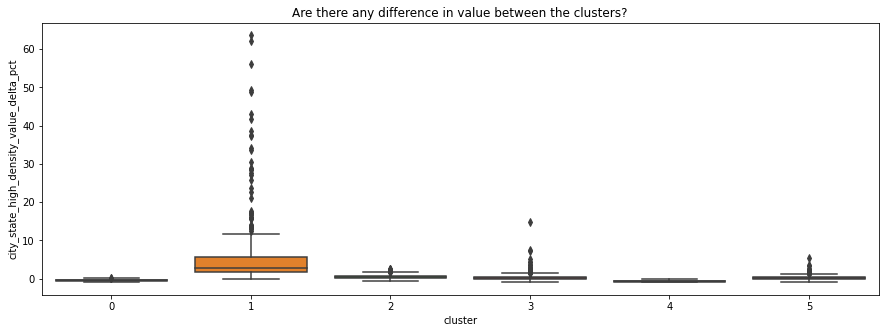

In [8]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x="cluster", y="city_state_high_density_value_delta_pct")
plt.title("Are there any difference in value between the clusters?")

Text(0.5, 1.0, 'Are there any difference in value between the clusters?')

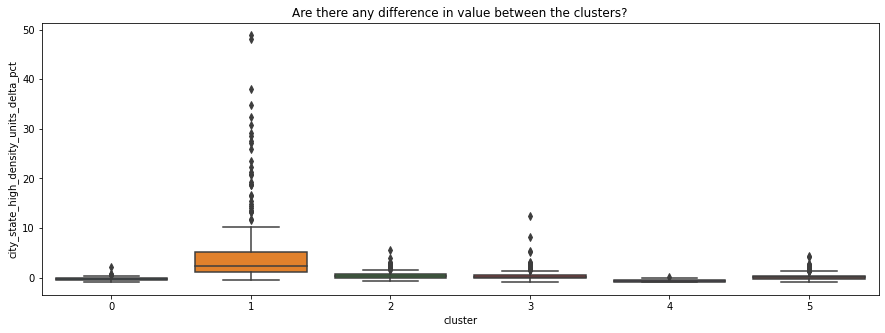

In [9]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x="cluster", y="city_state_high_density_units_delta_pct")
plt.title("Are there any difference in value between the clusters?")

In [10]:
# df[["avg_units_per_bldg", "ei"]] = scaler.inverse_transform(df[["avg_units_per_bldg", "ei"]])

In [11]:
df[df.ei >= 1].sort_values(by="ei").head(1).index

Int64Index([592], dtype='int64')

Text(0.5, 1.0, 'Are there any difference in value between the clusters?')

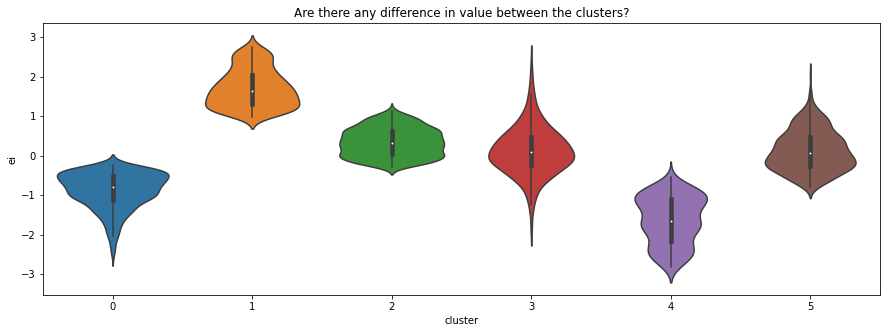

In [12]:
plt.figure(figsize=(15,5))
sns.violinplot(data=df, x="cluster", y="ei")
plt.title("Are there any difference in value between the clusters?")

Text(0.5, 1.0, 'Are there any difference in value between the clusters?')

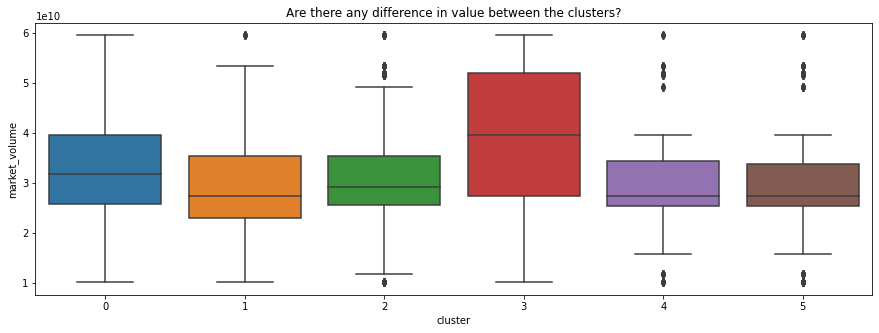

In [13]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x="cluster", y="market_volume")
plt.title("Are there any difference in value between the clusters?")

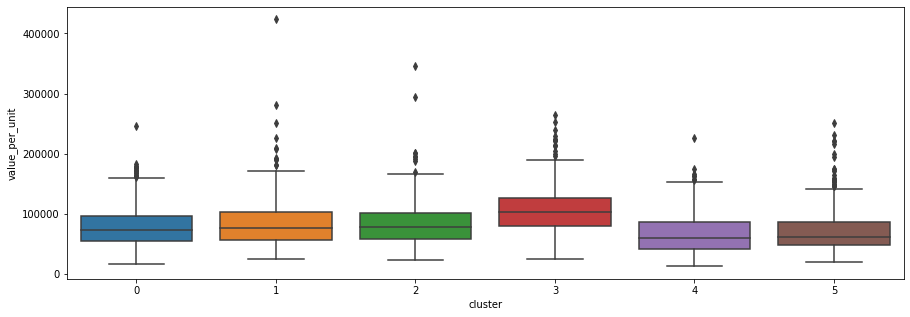

In [14]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x="cluster", y="value_per_unit")

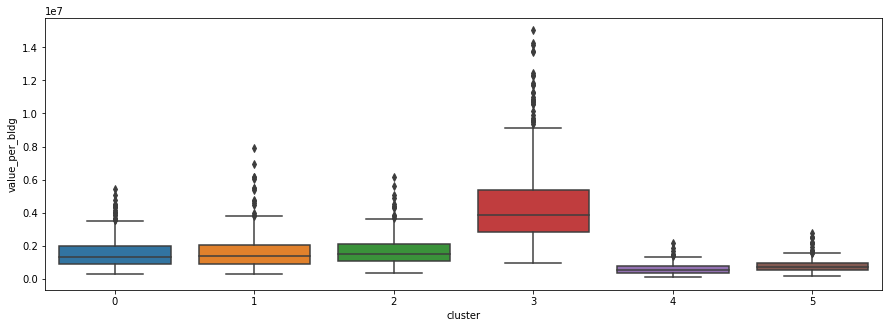

In [15]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x="cluster", y="value_per_bldg")

In [16]:
df.cluster = "cluster_" + df.cluster.astype(str)

Text(0.5, 1.0, 'Are there are any years that are clustered together?')

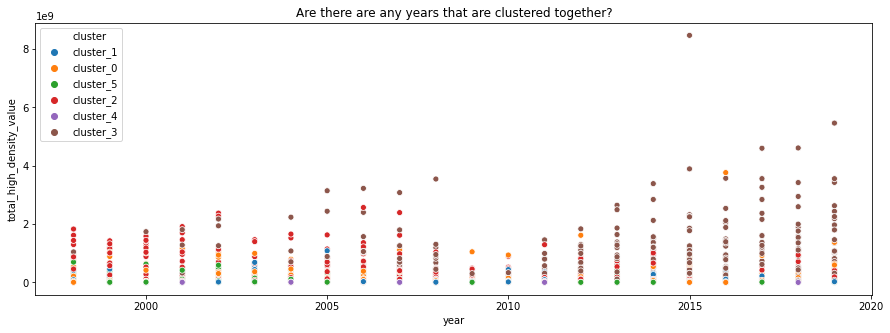

In [17]:
# Are there are any years that are clustered together?
plt.figure(figsize=(15,5))
sns.scatterplot(data=df, x="year", y="total_high_density_value", hue= "cluster")
plt.title("Are there are any years that are clustered together?")

Comments:

* It seems that cluster 3 might have been cities that experienced rapid growth on years that the market was big (meaning that there was a lot of money being invested, in comparison to other observations)

* Cluster 1 might be the smaller cities that are experincing signficantly faster growth than the rest of the market. For example, we might expect a city like Austin (which as recently undergone very rapid expansion to be in cluster 1) because they were smaller to start with, but significant investment has lead them to grow quicker than the market. 

## Exploring individual datapoints

In [18]:
df[df.cluster == "cluster_0"].sample()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster
2832,Tucson,AZ,2000,49.0,626.0,38731000.0,-0.560518,790428.571429,61870.607029,-0.436782,...,2.742204e+10,0.050818,-0.736582,Tucson_AZ,-0.430233,-0.127582,-0.040816,0.65374,False,cluster_0


In [19]:
phoenix = df[df.city == "Phoenix"]
phoenix

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster
2048,Phoenix,AZ,1998,722.0,10825.0,5.329850e+08,-0.238240,7.382064e+05,49236.489607,-0.176739,...,2.529787e+10,0.231085,-0.335631,Phoenix_AZ,NaN,NaN,0.211911,0.176889,False,cluster_0
2049,Phoenix,AZ,1999,723.0,8674.0,4.612760e+08,-0.689740,6.380028e+05,53179.156099,0.001385,...,2.609590e+10,0.031545,-0.251392,Phoenix_AZ,-0.175599,-0.157902,-0.221300,0.007787,False,cluster_5
2050,Phoenix,AZ,2000,875.0,10291.0,6.272640e+08,-0.730908,7.168731e+05,60952.677096,0.210235,...,2.742204e+10,0.050818,0.363310,Phoenix_AZ,0.211911,0.176889,-0.429714,-0.302012,False,cluster_5
2051,Phoenix,AZ,2001,563.0,8243.0,4.648680e+08,-0.285431,8.256980e+05,56395.487080,-0.356571,...,2.913103e+10,0.062322,-0.509733,Phoenix_AZ,-0.221300,0.007787,-0.236234,-0.063390,False,cluster_0
2052,Phoenix,AZ,2002,499.0,7343.0,4.378230e+08,-0.275365,8.774008e+05,59624.540379,-0.113677,...,3.169504e+10,0.088016,-0.207108,Phoenix_AZ,-0.429714,-0.302012,-0.036072,-0.056075,False,cluster_2
2053,Phoenix,AZ,2003,430.0,6823.0,4.354000e+08,-0.126501,1.012558e+06,63813.571743,-0.138277,...,2.305050e+10,-0.272741,0.440172,Phoenix_AZ,-0.236234,-0.063390,0.048837,0.250790,False,cluster_2
2054,Phoenix,AZ,2004,481.0,6293.0,4.132720e+08,-0.511983,8.591933e+05,65671.698713,0.118605,...,2.723856e+10,0.181691,-0.312890,Phoenix_AZ,-0.036072,-0.056075,-0.108108,0.765910,False,cluster_5
2055,Phoenix,AZ,2005,451.0,7476.0,5.445940e+08,-0.041187,1.207525e+06,72845.639379,-0.062370,...,3.435308e+10,0.261193,0.060698,Phoenix_AZ,0.048837,0.250790,0.274945,0.804443,False,cluster_2
2056,Phoenix,AZ,2006,429.0,6502.0,7.298010e+08,-0.216812,1.701168e+06,112242.540757,-0.048780,...,3.549408e+10,0.033214,0.366466,Phoenix_AZ,-0.108108,0.765910,-0.578089,-0.388130,False,cluster_2
2057,Phoenix,AZ,2007,575.0,9756.0,9.826890e+08,0.003939,1.709024e+06,100726.629766,0.340326,...,3.375194e+10,-0.049083,0.488532,Phoenix_AZ,0.274945,0.804443,-0.975652,-0.915605,False,cluster_2


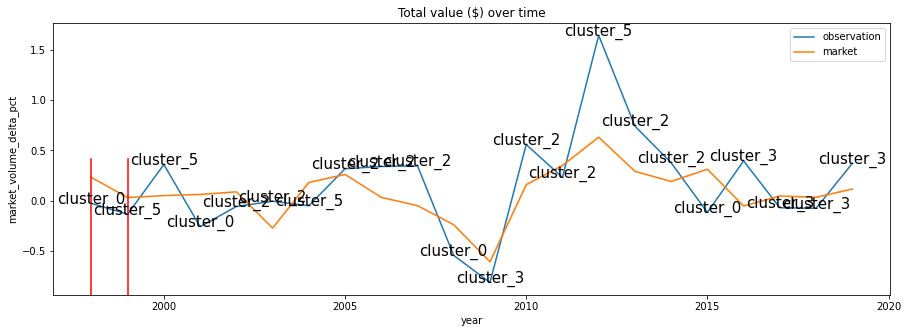

In [20]:
plt.figure(figsize=(15,5))
sns.lineplot(data=phoenix, x="year",y= "city_state_high_density_value_delta_pct", label="observation")
sns.lineplot(data=df, x="year", y="market_volume_delta_pct", label="market")
plt.title("Total value ($) over time")
for i in range(22):
    plt.text(
        phoenix.year.iloc[i],
        phoenix.city_state_high_density_value_delta_pct.iloc[i],
        f"{phoenix.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )
    
plt.axvline(1998, 0,.5, color="r")
plt.axvline(1999, 0,.5, color="r")

Takeways:

1. Cluster_5 is associated with the high peaks.
1. CLuster_0 and Cluster_3 are associasted with the crashes. 
1. Cluster_2 and Cluster_3 are associated with the medium growths. 

Population: 1.2 million (1998), growing (now 1.6 million)

---

In [21]:
df[df.cluster == "cluster_1"].sample()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster
2582,Sioux Falls,SD,2003,24.0,506.0,35924000.0,0.414466,1.496833e+06,70996.047431,-0.225806,...,2.305050e+10,-0.272741,1.237999,Sioux Falls_SD,-0.44186,0.013371,0.083333,-0.513779,False,cluster_1


In [22]:
erie = df[df.city == "Erie"]

In [23]:
erie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 921 to 942
Data columns (total 22 columns):
city                                       22 non-null object
state                                      22 non-null object
year                                       22 non-null int64
total_high_density_bldgs                   22 non-null float64
total_high_density_units                   22 non-null float64
total_high_density_value                   22 non-null float64
avg_units_per_bldg                         22 non-null float64
value_per_bldg                             22 non-null float64
value_per_unit                             22 non-null float64
city_state_high_density_bldgs_delta_pct    22 non-null float64
city_state_high_density_units_delta_pct    22 non-null float64
city_state_high_density_value_delta_pct    22 non-null float64
market_volume                              22 non-null float64
market_volume_delta_pct                    22 non-null float64
ei              

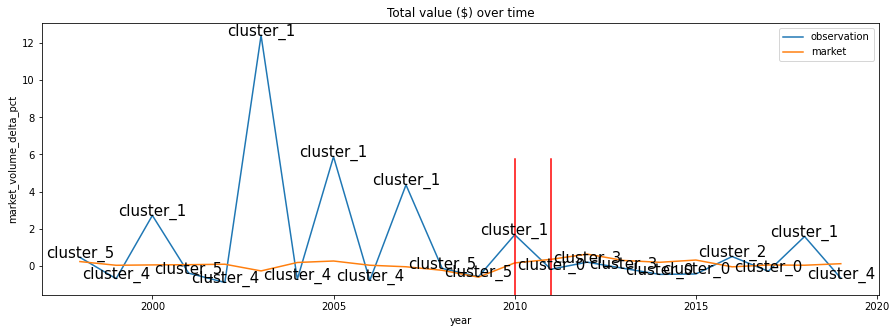

In [24]:
plt.figure(figsize=(15,5))
sns.lineplot(data=erie, x="year",y= "city_state_high_density_value_delta_pct", label="observation")
sns.lineplot(data=erie, x="year", y="market_volume_delta_pct", label="market")
plt.title("Total value ($) over time")
for i in range(22):
    plt.text(
        erie.year.iloc[i],
        erie.city_state_high_density_value_delta_pct.iloc[i],
        f"{erie.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )
plt.axvline(2010, 0,.5, color="r")
plt.axvline(2011, 0,.5, color="r")

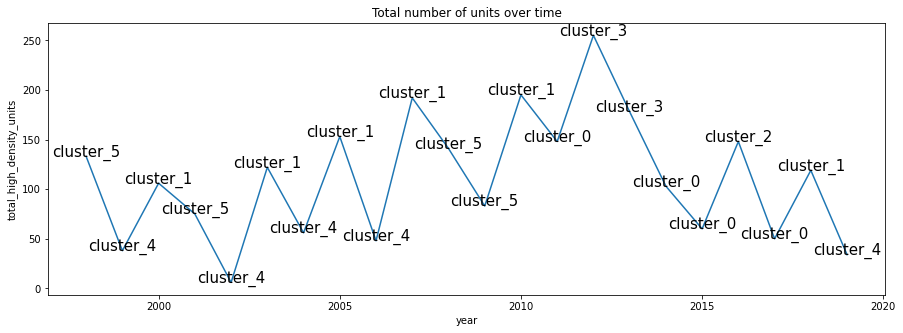

In [25]:
plt.figure(figsize=(15,5))
sns.lineplot(data=erie, x="year",y= "total_high_density_units")
plt.title("Total number of units over time")
for i in range(22):
    plt.text(
        erie.year.iloc[i],
        erie.total_high_density_units.iloc[i],
        f"{erie.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )

Overall, here are the things that I noticed:

1. Cluster_1 is usually associated with the high peaks
1. Cluster_0, Cluster_4 and Cluster_5 are usually associated with the crashes (in this market, these are also associated with the periods just before a spike).
1. Cluster_3 might be associated with higher units built, rather than dollars
1. Cluster_2 might be associated with medium growth

Population: ~ 96,000, with a decline in population since 1990

In [26]:
df[df.cluster == "cluster_2"].sample()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster
1266,Houston,TX,1998,2550.0,39796.0,1.618651e+09,-0.159087,634765.098039,40673.710926,0.958525,...,2.529787e+10,0.231085,0.575944,Houston_TX,NaN,NaN,-0.60549,-0.599632,False,cluster_2


In [27]:
spokane = df[df.city == "Spokane"]

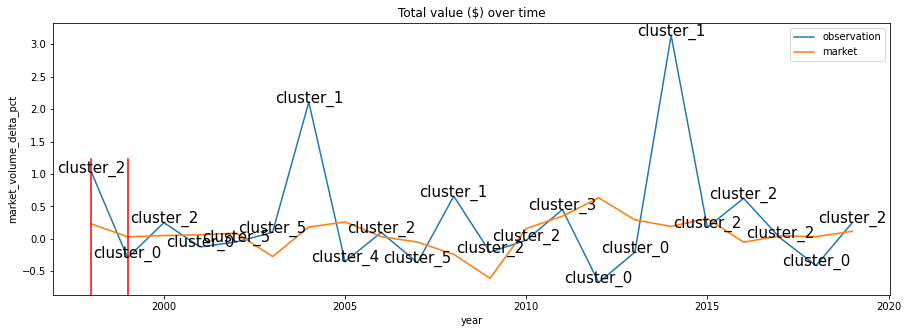

In [28]:
plt.figure(figsize=(15,5))
sns.lineplot(data=spokane, x="year",y= "city_state_high_density_value_delta_pct", label="observation")
sns.lineplot(data=df, x="year", y="market_volume_delta_pct", label="market")
plt.title("Total value ($) over time")
for i in range(22):
    plt.text(
        spokane.year.iloc[i],
        spokane.city_state_high_density_value_delta_pct.iloc[i],
        f"{spokane.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )
plt.axvline(1998, 0,.5, color="r")
plt.axvline(1999, 0,.5, color="r")

Takeaways:

1. Cluster_1 is associated with really high growth
1. Cluster_2 is associated with medium growth
1. Cluster_3 is associated with some growth, ubt only 1 instance
1. Cluster_0, Cluster_4 and Cluster_5 are associated with the low periods

Population: 

185,000 (1998), slight growth

In [29]:
df[df.cluster == "cluster_3"].sample()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster
2068,Phoenix,AZ,2018,223.0,7148.0,1.069304e+09,1.152294,4.795085e+06,149594.851707,-0.212014,...,5.336251e+10,0.034393,-0.162794,Phoenix_AZ,-0.138996,-0.141515,NaN,NaN,False,cluster_3


In [30]:
cs = df[df.city == "Colorado Springs"]

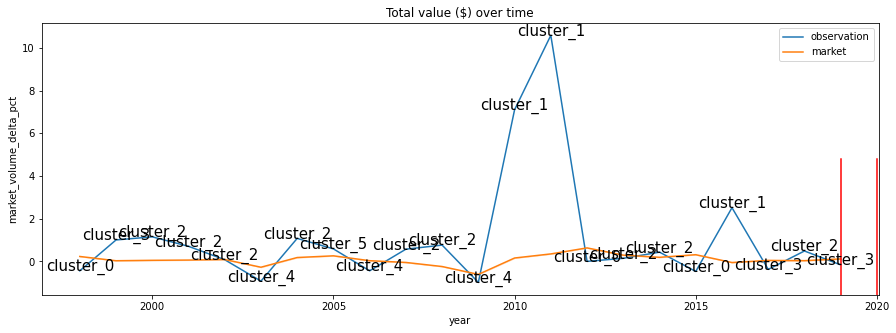

In [31]:
plt.figure(figsize=(15,5))
sns.lineplot(data=cs, x="year",y= "city_state_high_density_value_delta_pct", label="observation")
sns.lineplot(data=df, x="year", y="market_volume_delta_pct", label="market")
plt.title("Total value ($) over time")
for i in range(22):
    plt.text(
        cs.year.iloc[i],
        cs.city_state_high_density_value_delta_pct.iloc[i],
        f"{cs.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )
plt.axvline(2019, 0,.5, color="r")
plt.axvline(2020, 0,.5, color="r")

Takeaways:

1. Cluster_1 is associated with really high growth
1. Cluster_4, Cluster_0 and Cluster_3 are associated with low poitns
1. Cluster_2 is associated with medium growth

Population: 473,000 and growing

In [32]:
df[df.cluster == "cluster_4"].sample()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster
679,Colorado Springs,CO,2009,1.0,8.0,795000.0,-1.556387,795000.0,99375.0,-0.9375,...,1.005604e+10,-0.608193,-2.657017,Colorado Springs_CO,-0.944444,-0.974562,29.0,92.864151,True,cluster_4


In [33]:
naples = df[df.city == "Naples"]

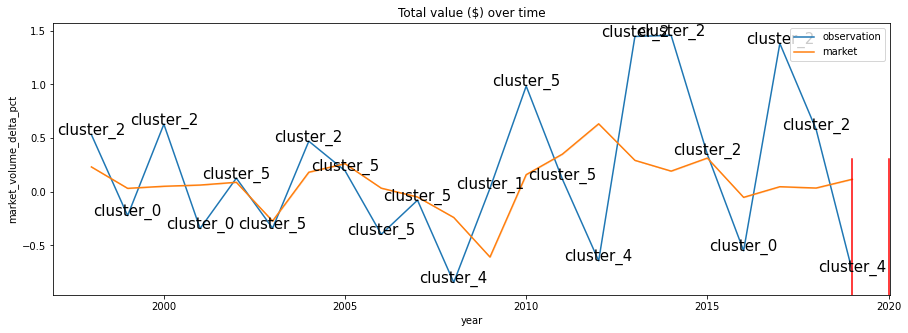

In [34]:
plt.figure(figsize=(15,5))
sns.lineplot(data=naples, x="year",y= "city_state_high_density_value_delta_pct", label="observation")
sns.lineplot(data=df, x="year", y="market_volume_delta_pct", label="market")
plt.title("Total value ($) over time")
for i in range(22):
    plt.text(
        naples.year.iloc[i],
        naples.city_state_high_density_value_delta_pct.iloc[i],
        f"{naples.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )
plt.axvline(2019, 0,.5, color="r")
plt.axvline(2020, 0,.5, color="r")

Takeaways:

1. Cluster_5 and Cluster_2 are associated with medium to high growth
1. Cluster_0 and Cluster_4 are associated with low points

population: 22,000 and flat

In [35]:
df[df.cluster == "cluster_5"].sample()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster
331,Boulder,CO,2006,26.0,238.0,19280000.0,-1.262133,741538.461538,81008.403361,0.238095,...,3.549408e+10,0.033214,-0.072462,Boulder_CO,0.529412,0.078239,0.0,3.380342,True,cluster_5


In [36]:
florence = df[df.city == "Florence"]

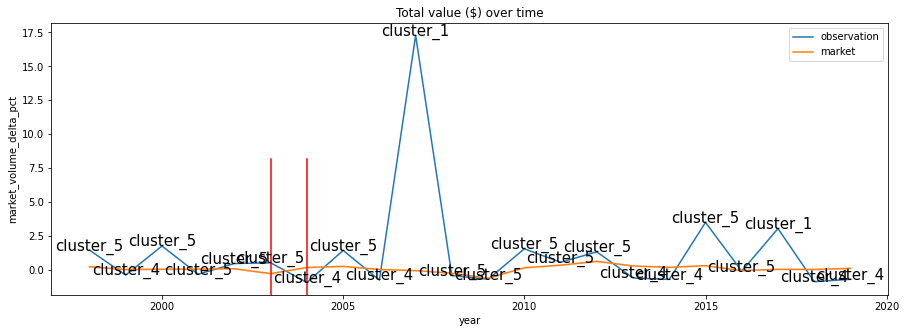

In [37]:
plt.figure(figsize=(15,5))
sns.lineplot(data=florence, x="year",y= "city_state_high_density_value_delta_pct", label="observation")
sns.lineplot(data=df, x="year", y="market_volume_delta_pct", label="market")
plt.title("Total value ($) over time")
for i in range(22):
    plt.text(
        florence.year.iloc[i],
        florence.city_state_high_density_value_delta_pct.iloc[i],
        f"{florence.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )
plt.axvline(2003, 0,.5, color="r")
plt.axvline(2004, 0,.5, color="r")

Takeaways:

1. Cluster_1 is associated with very large growth
1. Cluster_5 is associated is small growth
1. CLuster_4 is associated with lower growth periods

population: 40,000 and flat

In [38]:
df[df.ei == 0]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster


In [39]:
# assert(1 == 2)

# Label Creation

Current Ideas:

* It seems that the best markets are the ones in cluster_3, however, we need to be able to predict what observations will be in these markets two years before that happens. 
* We know that cluster_0 and cluster_4 are usually the underperforming markets, and usually market will transition from a low to a high. If we can predict those patterns, we can train the model.

In [40]:
df = permits_preprocessing_mother_function()

In [41]:
df, kmeans, centroids, scaler, scaled_ei_threshold_value, x = pr.create_clusters(df)

In [42]:
df.head()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster
1,Albany,NY,1998,47.0,1038.0,54232000.0,0.499727,1.153872e+06,52246.628131,0.566667,...,2.529787e+10,0.231085,1.200626,Albany_NY,NaN,NaN,-0.468085,-0.702574,False,1
2,Albany,NY,1999,39.0,515.0,24484000.0,-0.493115,6.277949e+05,47541.747573,-0.170213,...,2.609590e+10,0.031545,-1.118050,Albany_NY,0.300000,0.370041,0.435897,0.002124,False,0
3,Albany,NY,2000,25.0,346.0,16130000.0,-0.398138,6.452000e+05,46618.497110,-0.358974,...,2.742204e+10,0.050818,-0.655825,Albany_NY,-0.468085,-0.702574,0.880000,0.837198,False,0
4,Albany,NY,2001,56.0,502.0,24536000.0,-1.307457,4.381429e+05,48876.494024,1.240000,...,2.913103e+10,0.062322,0.503915,Albany_NY,0.435897,0.002124,-0.214286,0.539167,False,5
5,Albany,NY,2002,47.0,475.0,29634000.0,-1.049695,6.305106e+05,62387.368421,-0.160714,...,3.169504e+10,0.088016,0.146820,Albany_NY,0.880000,0.837198,0.297872,0.825639,False,5


In [43]:
# df["previous_cluster"] = df.cluster.shift(-2)

In [44]:
# df["future_cluster"] = df.cluster.shift(-2)

In [45]:
df["test_future_cluster"] = (df.sort_values(["year"])
                                  .groupby(["city", "state"])[["cluster"]]
                                  .shift(-2))

In [46]:
df[["city", "year", "cluster", "test_future_cluster"]].head(50)

,city,year,cluster,test_future_cluster
1,Albany,1998,1,0.0
2,Albany,1999,0,5.0
3,Albany,2000,0,5.0
4,Albany,2001,5,5.0
5,Albany,2002,5,5.0
6,Albany,2003,5,5.0
7,Albany,2004,5,0.0
8,Albany,2005,5,2.0
9,Albany,2006,0,2.0
10,Albany,2007,2,4.0


In [47]:
df[df.city == "Austin"]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster,test_future_cluster
139,Austin,TX,1998,289.0,5128.0,1.788780e+08,0.090118,6.189550e+05,34882.605304,0.066421,...,0.231085,-0.389756,Austin_TX,NaN,NaN,0.833910,0.847371,False,0,2.0
140,Austin,TX,1999,452.0,7849.0,3.191310e+08,0.048674,7.060420e+05,40658.810039,0.564014,...,0.031545,0.758928,Austin_TX,0.667897,0.670240,0.011062,-0.036750,False,2,2.0
141,Austin,TX,2000,530.0,8064.0,3.304540e+08,-0.209140,6.234981e+05,40978.918651,0.172566,...,0.050818,-0.022754,Austin_TX,0.833910,0.847371,-0.501887,-0.351852,False,2,0.0
142,Austin,TX,2001,457.0,8345.0,3.074030e+08,0.144914,6.726543e+05,36836.788496,-0.137736,...,0.062322,-0.190749,Austin_TX,0.011062,-0.036750,-0.743982,-0.556849,False,2,2.0
143,Austin,TX,2002,264.0,5570.0,2.141830e+08,0.415793,8.112992e+05,38452.962298,-0.422319,...,0.088016,-0.627059,Austin_TX,-0.501887,-0.351852,-0.295455,-0.177675,False,0,2.0
144,Austin,TX,2003,117.0,2499.0,1.362260e+08,0.438412,1.164325e+06,54512.204882,-0.556818,...,-0.272741,-0.192562,Austin_TX,-0.743982,-0.556849,1.222222,1.058197,False,2,2.0
145,Austin,TX,2004,186.0,3106.0,1.761280e+08,-0.026901,9.469247e+05,56705.730844,0.589744,...,0.181691,0.126252,Austin_TX,-0.295455,-0.177675,0.290323,1.792656,False,2,3.0
146,Austin,TX,2005,260.0,5261.0,2.803800e+08,0.338272,1.078385e+06,53294.050561,0.397849,...,0.261193,0.328360,Austin_TX,1.222222,1.058197,-0.026923,1.501027,False,2,2.0
147,Austin,TX,2006,240.0,7399.0,4.918650e+08,1.086676,2.049438e+06,66477.226652,-0.076923,...,0.033214,0.734511,Austin_TX,0.290323,1.792656,-0.483333,-0.040668,False,3,3.0
148,Austin,TX,2007,253.0,6902.0,7.012380e+08,0.876725,2.771692e+06,101599.246595,0.054167,...,-0.049083,0.566971,Austin_TX,-0.026923,1.501027,-0.735178,-0.752707,False,2,3.0


In [48]:
df_potential = df[((df.test_future_cluster == 3) | (df.test_future_cluster == 1)) & ((df.cluster == 4) | (df.cluster == 0) | (df.cluster == 2))]

In [49]:
df_potential.city.value_counts()

Springfield     7
Tuscaloosa      6
Birmingham      6
New York        6
New Orleans     6
               ..
Clarksville     1
Las Vegas       1
Indianapolis    1
Fayetteville    1
Brownsville     1
Name: city, Length: 121, dtype: int64

In [50]:
df_potential

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster,test_future_cluster
12,Albany,NY,2009,17.0,180.0,7461000.0,-0.950904,4.388824e+05,41450.000000,-0.433333,...,-0.608193,-1.778978,Albany_NY,-0.760563,-0.923942,3.176471,10.349283,True,4,1.0
16,Albany,NY,2013,57.0,683.0,66173000.0,-0.692289,1.160930e+06,96885.797950,-0.337209,...,0.292291,-0.955517,Albany_NY,-0.197183,-0.218525,1.491228,2.979538,True,0,1.0
19,Albany,NY,2016,70.0,1120.0,113414000.0,-0.110207,1.620200e+06,101262.500000,-0.507042,...,-0.052294,-1.072188,Albany_NY,0.000000,0.322473,-0.314286,0.894087,False,0,1.0
30,Albuquerque,NM,2004,16.0,324.0,15510000.0,0.339687,9.693750e+05,47870.370370,-0.515152,...,0.181691,-0.864080,Albuquerque_NM,-0.764706,-0.663046,1.500000,2.890974,True,0,1.0
31,Albuquerque,NM,2005,10.0,273.0,13852000.0,0.877961,1.385200e+06,50739.926740,-0.375000,...,0.261193,-0.489042,Albuquerque_NM,-0.696970,-0.434520,1.300000,2.315767,False,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938,Wilmington,NC,2014,24.0,823.0,63833000.0,1.264537,2.659708e+06,77561.360875,0.263158,...,0.191969,-1.035359,Wilmington_NC,-0.538462,-0.423541,0.625000,0.730954,False,0,1.0
2954,Worcester,MA,2007,5.0,71.0,2975000.0,-0.346558,5.950000e+05,41901.408451,-0.705882,...,-0.049083,-2.251914,Worcester_MA,-0.545455,-0.823641,2.000000,6.772101,True,4,1.0
2958,Worcester,MA,2011,2.0,48.0,6740000.0,0.650262,3.370000e+06,140416.666667,-0.777778,...,0.350568,-1.776579,Worcester_MA,-0.866667,-0.708503,0.500000,-0.252226,False,0,3.0
2961,Worcester,MA,2014,3.0,58.0,4637000.0,0.252978,1.545667e+06,79948.275862,0.000000,...,0.191969,-0.368903,Worcester_MA,-0.571429,-0.434857,1.666667,4.495579,True,0,3.0


In [51]:
df_potential[df_potential.city == "Atlanta"]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster,test_future_cluster
118,Atlanta,GA,2000,699.0,16820.0,890199000.0,0.654958,1.273532e+06,52925.029727,0.465409,...,0.050818,0.407363,Atlanta_GA,0.275547,0.685389,-0.240343,0.008036,False,2,3.0
119,Atlanta,GA,2001,660.0,16361.0,963297000.0,0.708091,1.459541e+06,58877.635841,-0.055794,...,0.062322,0.024497,Atlanta_GA,0.383648,0.518656,-0.542424,-0.343811,False,2,3.0
127,Atlanta,GA,2009,36.0,994.0,105936000.0,0.897666,2.942667e+06,106575.452716,-0.777778,...,-0.608193,-1.232511,Atlanta_GA,-0.902439,-0.913938,1.305556,0.907151,False,0,3.0
128,Atlanta,GA,2010,62.0,1101.0,94521000.0,0.091641,1.524532e+06,85850.136240,0.722222,...,0.159076,-0.372677,Atlanta_GA,-0.617284,-0.861064,1.548387,4.499656,True,0,3.0


In [52]:
atlanta = df[df.city == "Atlanta"]

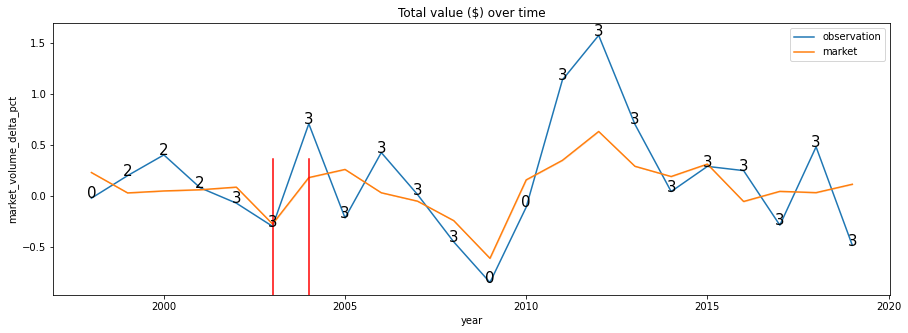

In [53]:
plt.figure(figsize=(15,5))
sns.lineplot(data=atlanta, x="year",y= "city_state_high_density_value_delta_pct", label="observation")
sns.lineplot(data=df, x="year", y="market_volume_delta_pct", label="market")
plt.title("Total value ($) over time")
for i in range(22):
    plt.text(
        atlanta.year.iloc[i],
        atlanta.city_state_high_density_value_delta_pct.iloc[i],
        f"{atlanta.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )
plt.axvline(2003, 0,.5, color="r")
plt.axvline(2004, 0,.5, color="r")

plt.show()

In [54]:
df_potential[df_potential.city == "Dallas"]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster,test_future_cluster
767,Dallas,TX,2005,509.0,9812.0,694394000.0,0.247488,1.364232e+06,70769.873624,0.288608,...,0.261193,0.312789,Dallas_TX,-0.132879,0.117224,-0.037328,0.771893,False,2,3.0
768,Dallas,TX,2006,456.0,11998.0,979997000.0,0.813459,2.149116e+06,81680.030005,-0.104126,...,0.033214,0.438662,Dallas_TX,0.154430,1.221903,0.300439,0.221789,False,2,3.0
771,Dallas,TX,2009,234.0,5933.0,489735000.0,0.748133,2.092885e+06,82544.244059,-0.605396,...,-0.608193,0.059428,Dallas_TX,-0.522449,-0.601968,0.512821,0.673372,False,2,3.0
772,Dallas,TX,2010,203.0,4990.0,479537000.0,0.693067,2.362251e+06,96099.599198,-0.132479,...,0.159076,-0.241644,Dallas_TX,-0.657673,-0.599501,1.246305,1.472987,False,2,3.0


In [55]:
dallas = df[df.city == "Dallas"]

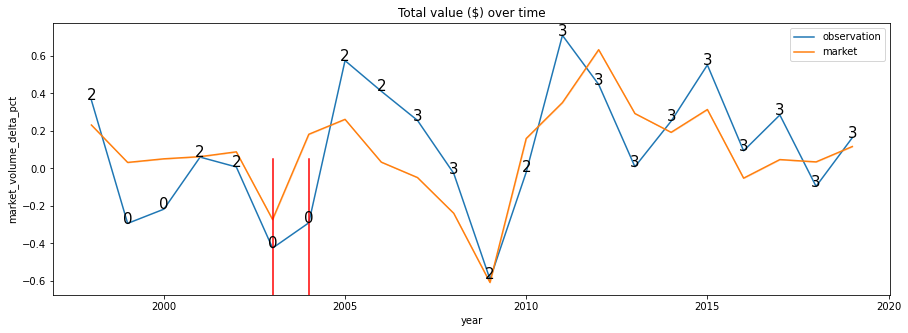

In [56]:
plt.figure(figsize=(15,5))
sns.lineplot(data=dallas, x="year",y= "city_state_high_density_value_delta_pct", label="observation")
sns.lineplot(data=df, x="year", y="market_volume_delta_pct", label="market")
plt.title("Total value ($) over time")
for i in range(22):
    plt.text(
        dallas.year.iloc[i],
        dallas.city_state_high_density_value_delta_pct.iloc[i],
        f"{dallas.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )
plt.axvline(2003, 0,.5, color="r")
plt.axvline(2004, 0,.5, color="r")

In [57]:
df_potential[df_potential.city == "Boston"]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster,test_future_cluster
306,Boston,MA,2004,295.0,6037.0,6.018870e+08,0.359281,2.040295e+06,99699.685274,0.378505,...,0.181691,0.060132,Boston_MA,0.042403,0.355873,-0.206780,0.047765,False,2,3.0
313,Boston,MA,2011,131.0,2321.0,3.257510e+08,0.087266,2.486649e+06,140349.418354,-0.229412,...,0.350568,-0.030429,Boston_MA,-0.015038,0.393778,0.404580,4.041958,True,2,3.0
316,Boston,MA,2014,225.0,6482.0,1.145235e+09,0.971053,5.089933e+06,176679.265659,0.222826,...,0.191969,-0.748717,Boston_MA,0.236264,0.805265,0.093333,0.179576,False,0,3.0


In [58]:
boston = df[df.city == "Boston"]

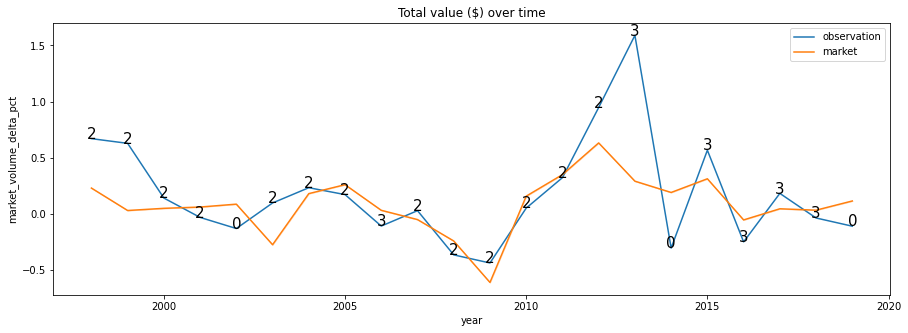

In [59]:
plt.figure(figsize=(15,5))
sns.lineplot(data=boston, x="year",y= "city_state_high_density_value_delta_pct", label="observation")
sns.lineplot(data=df, x="year", y="market_volume_delta_pct", label="market")
plt.title("Total value ($) over time")
for i in range(22):
    plt.text(
        boston.year.iloc[i],
        boston.city_state_high_density_value_delta_pct.iloc[i],
        f"{boston.cluster.iloc[i]}",
        color = 'black',
        fontsize=15,
        ha ="center"
    )
    
plt.show()


In [60]:
centroids

,avg_units_per_bldg,ei
0,0.134099,-0.882271
1,0.023700,1.710680
2,0.231324,0.344536
3,1.465900,0.120773
4,-1.407036,-1.636162
5,-0.995691,0.127961


# Labels

Desired_labels:

    emerging market
    declining market
    stable_high
    stable_low

## Emerging Market

In [61]:
df = permits_preprocessing_mother_function()
df, kmeans, centroids, scaler, scaled_ei_threshold_value, x = pr.create_clusters(df)

In [62]:
df["test_future_cluster"] = (df.sort_values(["year"])
                                  .groupby(["city", "state"])[["cluster"]]
                                  .shift(-2))

In [63]:
# df_emerging = (
#     df[((df.test_future_cluster == 3) | (df.test_future_cluster == 1) | (df.test_future_cluster == 2)) 
#        & ((df.cluster == 4) | (df.cluster == 0) | (df.cluster == 5))]
# )

In [64]:
df_emerging = (
    df[((df.test_future_cluster == 3) | (df.test_future_cluster == 1)) 
       & ((df.cluster == 4) | (df.cluster == 0))]
)

In [65]:
df_emerging.head()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster,test_future_cluster
12,Albany,NY,2009,17.0,180.0,7461000.0,-0.950904,4.388824e+05,41450.00000,-0.433333,...,-0.608193,-1.778978,Albany_NY,-0.760563,-0.923942,3.176471,10.349283,True,4,1.0
16,Albany,NY,2013,57.0,683.0,66173000.0,-0.692289,1.160930e+06,96885.79795,-0.337209,...,0.292291,-0.955517,Albany_NY,-0.197183,-0.218525,1.491228,2.979538,True,0,1.0
19,Albany,NY,2016,70.0,1120.0,113414000.0,-0.110207,1.620200e+06,101262.50000,-0.507042,...,-0.052294,-1.072188,Albany_NY,0.000000,0.322473,-0.314286,0.894087,False,0,1.0
30,Albuquerque,NM,2004,16.0,324.0,15510000.0,0.339687,9.693750e+05,47870.37037,-0.515152,...,0.181691,-0.864080,Albuquerque_NM,-0.764706,-0.663046,1.500000,2.890974,True,0,1.0
31,Albuquerque,NM,2005,10.0,273.0,13852000.0,0.877961,1.385200e+06,50739.92674,-0.375000,...,0.261193,-0.489042,Albuquerque_NM,-0.696970,-0.434520,1.300000,2.315767,False,0,3.0


## Declining Market

In [66]:
df_declining = (
    df[((df.test_future_cluster == 4) | (df.test_future_cluster == 0) | (df.test_future_cluster == 5)) 
       & ((df.cluster == 1) | (df.cluster == 3) | (df.cluster == 2))]
)

In [67]:
df_declining["new_label"] = "declining_market"

In [68]:
df_declining.head()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster,test_future_cluster,new_label
1,Albany,NY,1998,47.0,1038.0,54232000.0,0.499727,1.153872e+06,52246.628131,0.566667,...,1.200626,Albany_NY,NaN,NaN,-0.468085,-0.702574,False,1,0.0,declining_market
10,Albany,NY,2007,71.0,981.0,98096000.0,-0.401502,1.381634e+06,99995.922528,1.088235,...,0.932790,Albany_NY,-0.371681,-0.060203,-0.760563,-0.923942,False,2,4.0,declining_market
11,Albany,NY,2008,30.0,618.0,81793000.0,0.371543,2.726433e+06,132351.132686,-0.577465,...,0.129342,Albany_NY,-0.117647,0.568478,-0.200000,-0.799090,False,2,5.0,declining_market
14,Albany,NY,2011,71.0,768.0,84677000.0,-0.905840,1.192634e+06,110256.510417,1.958333,...,1.659246,Albany_NY,3.176471,10.349283,-0.197183,-0.218525,False,1,0.0,declining_market
18,Albany,NY,2015,142.0,2132.0,263338000.0,-0.235464,1.854493e+06,123516.885553,1.028571,...,1.138070,Albany_NY,1.491228,2.979538,-0.563380,-0.633813,False,1,0.0,declining_market


## Stable High

In [69]:
df_stable_high = (
    df[((df.test_future_cluster == 1) | (df.test_future_cluster == 3) | (df.test_future_cluster == 5)) 
       & ((df.cluster == 1) | (df.cluster == 3)) | (df.cluster == 5)]
)

In [70]:
df_stable_high["new_label"] = "stable_high"

In [71]:
df_stable_high.head()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster,test_future_cluster,new_label
4,Albany,NY,2001,56.0,502.0,24536000.0,-1.307457,438142.857143,48876.494024,1.240000,...,0.503915,Albany_NY,0.435897,0.002124,-0.214286,0.539167,False,5,5.0,stable_high
5,Albany,NY,2002,47.0,475.0,29634000.0,-1.049695,630510.638298,62387.368421,-0.160714,...,0.146820,Albany_NY,0.880000,0.837198,0.297872,0.825639,False,5,5.0,stable_high
6,Albany,NY,2003,44.0,554.0,37765000.0,-0.590310,858295.454545,68167.870036,-0.063830,...,0.776178,Albany_NY,-0.214286,0.539167,1.568182,1.763935,False,5,5.0,stable_high
7,Albany,NY,2004,61.0,614.0,54101000.0,-1.058312,886901.639344,88112.377850,0.386364,...,0.271562,Albany_NY,0.297872,0.825639,-0.442623,-0.036099,False,5,0.0,stable_high
8,Albany,NY,2005,113.0,1294.0,104380000.0,-0.786431,923716.814159,80664.605873,0.852459,...,0.594437,Albany_NY,1.568182,1.763935,-0.371681,-0.060203,False,5,2.0,stable_high


## Stable Low

In [72]:
df_stable_low = (
    df[
        ((df.cluster == 4) | (df.cluster == 0) | (df.cluster == 2)) 
        & ((df.test_future_cluster == 4) | (df.test_future_cluster == 0) | (df.test_future_cluster == 2))
    ]
)

In [73]:
df_stable_low["new_label"] = "stable_low"

In [74]:
df_stable_low.head()

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster,test_future_cluster,new_label
9,Albany,NY,2006,34.0,494.0,52148000.0,-0.300710,1.533765e+06,105562.753036,-0.699115,...,-0.995144,Albany_NY,-0.442623,-0.036099,-0.117647,0.568478,False,0,2.0,stable_low
10,Albany,NY,2007,71.0,981.0,98096000.0,-0.401502,1.381634e+06,99995.922528,1.088235,...,0.932790,Albany_NY,-0.371681,-0.060203,-0.760563,-0.923942,False,2,4.0,stable_low
20,Albany,NY,2017,62.0,925.0,96431000.0,-0.248016,1.555339e+06,104249.729730,-0.114286,...,-0.297136,Albany_NY,-0.563380,-0.633813,-0.225806,-0.373065,False,0,0.0,stable_low
24,Albuquerque,NM,1998,13.0,388.0,12679000.0,1.031626,9.753077e+05,32677.835052,-0.745098,...,-2.138464,Albuquerque_NM,NaN,NaN,-0.769231,-0.749586,False,0,0.0,stable_low
26,Albuquerque,NM,2000,3.0,70.0,3175000.0,0.599576,1.058333e+06,45357.142857,-0.880000,...,-1.714803,Albuquerque_NM,-0.769231,-0.749586,21.666667,13.497638,True,0,2.0,stable_low


In [75]:
df["new_label"] = np.nan

In [76]:
df.new_label = df.new_label.fillna(df_stable_low.new_label)

In [77]:
df.new_label = df.new_label.fillna(df_stable_high.new_label)

In [78]:
df.new_label = df.new_label.fillna(df_declining.new_label)

In [79]:
df.new_label = df.new_label.fillna(df_emerging.should_enter)

In [80]:
df.new_label.value_counts(dropna=False)

stable_high         999
stable_low          776
NaN                 648
declining_market    238
False               122
True                 77
Name: new_label, dtype: int64

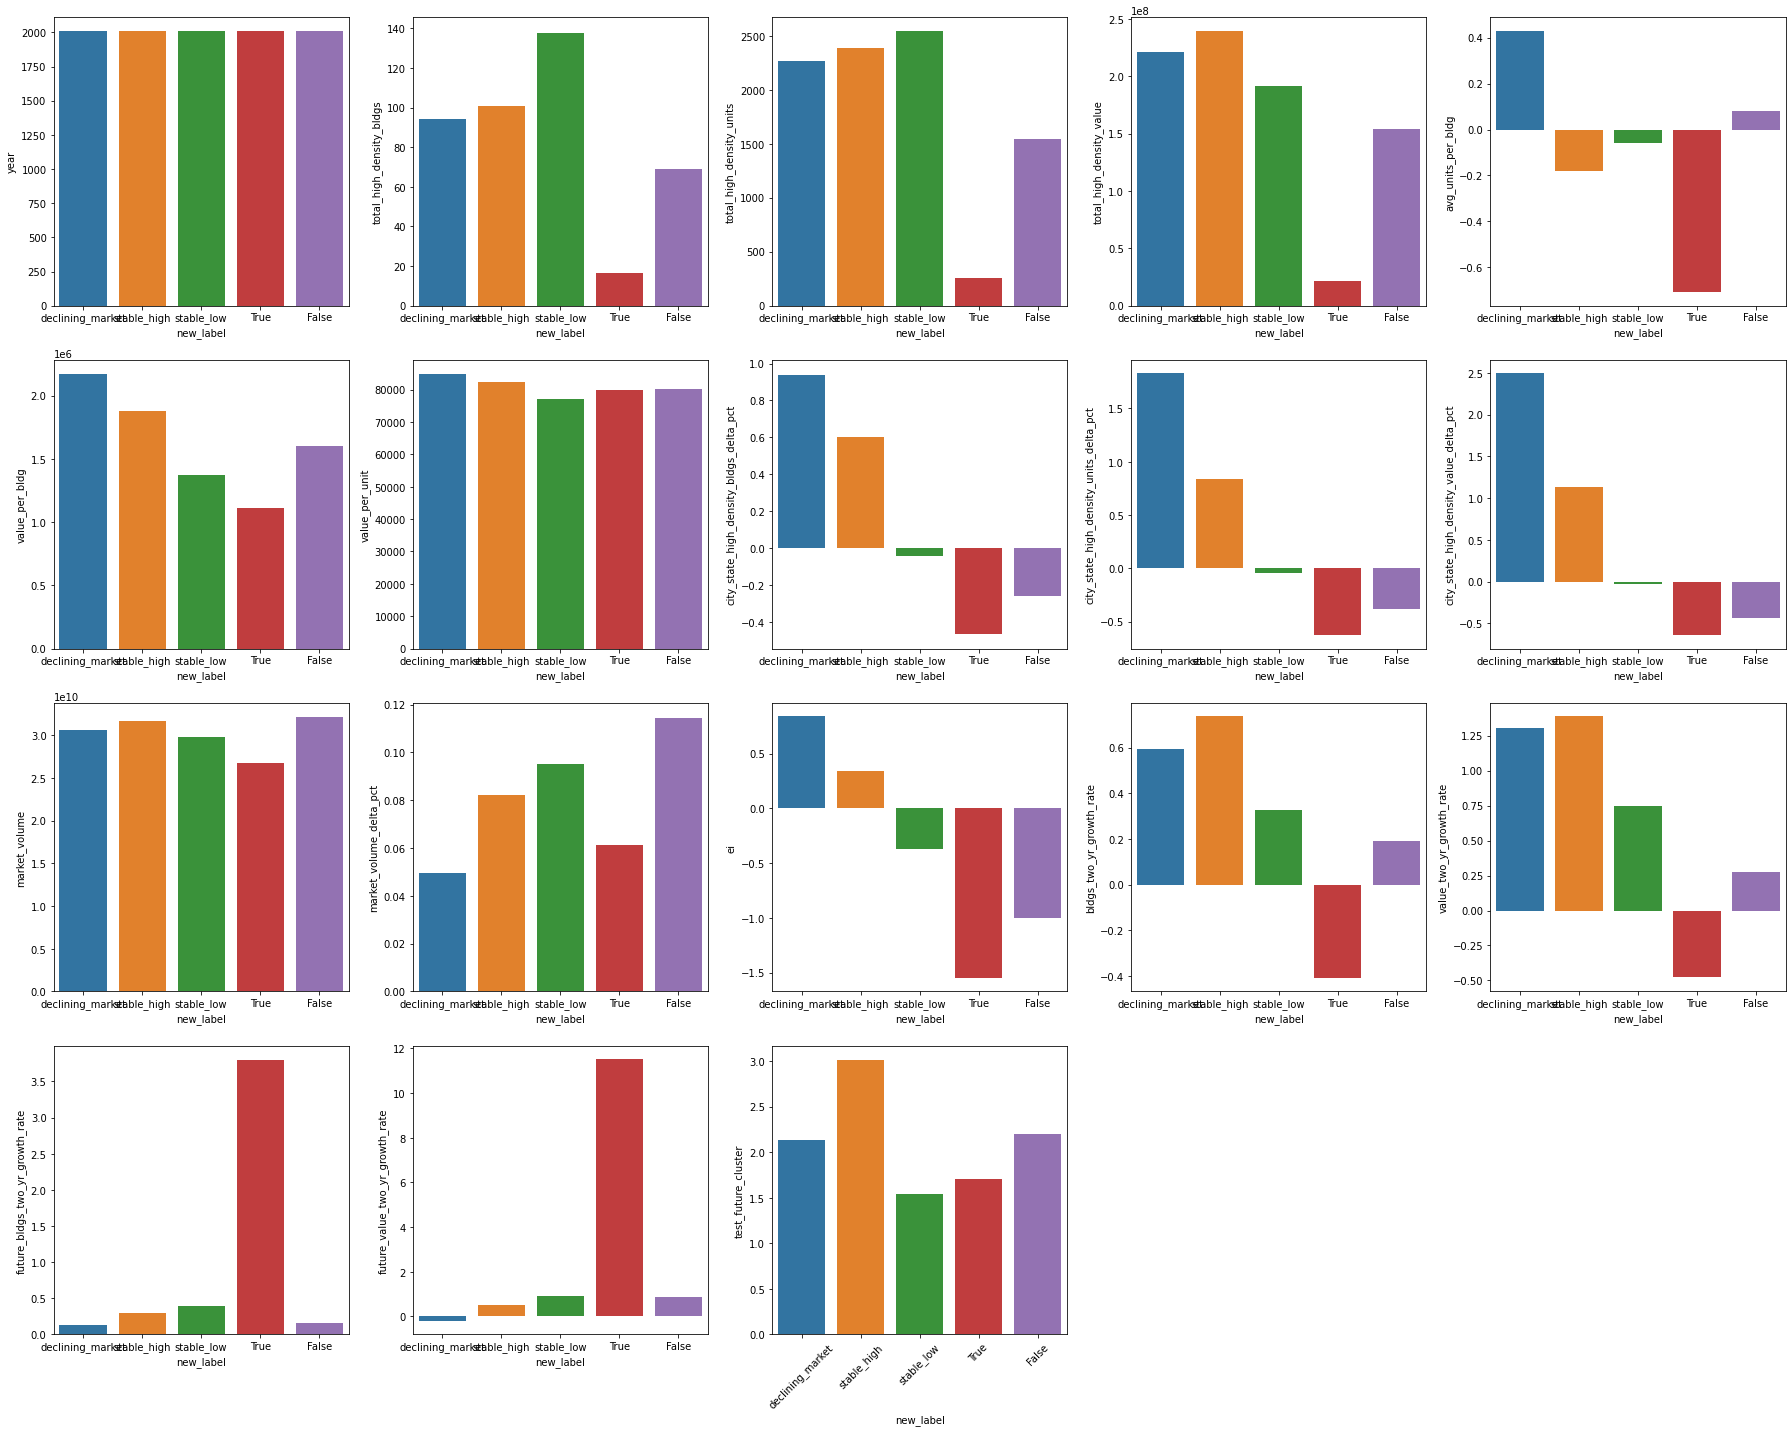

In [81]:
f = plt.figure(figsize=(25,20))
continuous_data = df.select_dtypes(include=["int", "float"])

for count, element in enumerate(continuous_data):
    f.add_subplot(4,5, count+1)
    sns.barplot(data=df, x="new_label", y=element, ci=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2860 entries, 1 to 2989
Data columns (total 24 columns):
city                                       2860 non-null object
state                                      2860 non-null object
year                                       2860 non-null int64
total_high_density_bldgs                   2860 non-null float64
total_high_density_units                   2860 non-null float64
total_high_density_value                   2860 non-null float64
avg_units_per_bldg                         2860 non-null float64
value_per_bldg                             2860 non-null float64
value_per_unit                             2860 non-null float64
city_state_high_density_bldgs_delta_pct    2860 non-null float64
city_state_high_density_units_delta_pct    2860 non-null float64
city_state_high_density_value_delta_pct    2860 non-null float64
market_volume                              2860 non-null float64
market_volume_delta_pct                    2860 non-

-----

# Modeling

We will be using classification algorithms to predict what markets will be hot as of 2020/2021. This will help us create recommendations for the future, so that we know what market's will be worth investing resources and labor in, and what martek's are worth ignoring.

We will be likely using the following features for modeling:

```python
features_for_modeling = ["ei_x", "avg_units_per_bldg_x", "cluster", "market_volume_delta_pct", "total_high_density_value"]
```

Our target variable (the variable we are trying to predict, will be:

```python
label_feature = "should_enter"
```

In this case, our positive case will be `should_enter_market`. 


When looking at our confusion matrix, and all of it's possible outcomes, it would likely look as follows:

| Matrix | Actual Positive | Actual Negative |
|--------|-----------------|-----------------|
| Predicted Positive | `enter_market` | predicted `not_enter_market`, but really it was a hot market and a missed opportunity | 
| Predicted Negative | predicted `enter_market`, but really it was a cold market, and not worth investing | `not_enter_market`


Traditionally, for a project like this one, we would have focus on reducing the number of `False_Positives`, because it would be far more expensive to the stakeholder if we predicted a city was going to be hot, they spend time and money, and their investment is not returned. However, because TestFit's business strategy and software deployment are all done online, with very little investment needed for traveling. This means that actually investing in a city is not costly at all. As such, we will optimize our models to reduce the number of `False_Negtives`, because we want to make sure we are not missing any potential markets that can be considered `hot markets` in 2020 and 2021.

Given that we have a low number of `positive` labels in our data, we will have to do something called **Oversampling**. This is a practice use in the field to basically help the predictive model by calling attention to the postiive labels and their patterns. We will create duplicate positive values, so that the model becomes more effective at predicting these values. Initially, about 7% of our data had a positive label. After oversampling, we have increased the positive value to be ~25% of the total population.

In [83]:
def split_data(df, label_feature, train_size=.75,random_state = 124):
    train, test = train_test_split(df, train_size=train_size, random_state=random_state, stratify = df[label_feature])
    train, validate = train_test_split(train, train_size=train_size, random_state=random_state, stratify = train[label_feature])
    return train, validate, test

def return_values(scaler, train, validate, test):
    '''
    Helper function used to updated the scaled arrays and transform them into usable dataframes
    '''
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
    validate_scaled = pd.DataFrame(scaler.transform(validate), columns=validate.columns.values).set_index([validate.index.values])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns.values).set_index([test.index.values])
    return scaler, train_scaled, validate_scaled, test_scaled

# Linear scaler
def min_max_scaler(train,validate, test):
    '''
    Helper function that scales that data. Returns scaler, as well as the scaled dataframes
    '''
    scaler = MinMaxScaler().fit(train)
    scaler, train_scaled, validate_scaled, test_scaled = return_values(scaler, train, validate, test)
    return scaler, train_scaled, validate_scaled, test_scaled

def prep_data_for_modeling_permits(df, features_for_modeling, label_feature):

    # To avoid Nan's, I have removed all data from 2006 (because all the var's would be nan)
    df_model = df[df.year > 1997]
    


    # Create an observation id to reduce the chance of mistake's
    df_model["observation_id"] = df_model.city + "_" + df_model.state + "_"  + df_model.year.astype(str)

    # select that features that we want to model, and use our observation id as the row id
    features_for_modeling += ["observation_id"]

    features_for_modeling += [label_feature]

    data = df_model[features_for_modeling].set_index("observation_id")
    
    train, validate, test = split_data(data, label_feature)
    train = train.sort_values("observation_id")
    validate = validate.sort_values("observation_id")
    test = test.sort_values("observation_id")
    
    
    X_train = train.drop(columns=label_feature)
    y_train = train[label_feature]
    X_validate = validate.drop(columns=label_feature)
    y_validate = validate[label_feature]
    X_test = test.drop(columns=label_feature)
    y_test = test[label_feature]
    
    scaler, train_scaled, validate_scaled, test_scaled = min_max_scaler(X_train, X_validate, X_test)

    return train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test

In [84]:
df = permits_preprocessing_mother_function()
df, kmeans, centroids, scaler, scaled_ei_threshold_value, x = pr.create_clusters(df)

In [85]:
# ## When predicting a multivariate target
# df["new_label"] = np.nan

# df.new_label = df.new_label.fillna(df_stable_low.new_label)

# df.new_label = df.new_label.fillna(df_stable_high.new_label)

# df.new_label = df.new_label.fillna(df_declining.new_label)

# df.new_label = df.new_label.fillna(df_emerging.new_label)

In [86]:
# # When predicting a bool (emerging_market + stable_high)

# target = pd.concat([df_emerging, df_stable_high])

# target["should_enter"] = True

# df["should_enter"] = target.should_enter

# df.should_enter = df.should_enter.fillna(False)

In [87]:
# When predicting a bool (emerging_market only)

df_emerging["should_enter"] = True

df["should_enter"] = df_emerging.should_enter

df.should_enter = df.should_enter.fillna(False)

In [88]:
df = df.merge(centroids, how="left", left_on="cluster", right_on=centroids.index)

In [89]:
df = df[df.year < 2018]

In [90]:
df

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg_x,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,...,ei_x,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster,avg_units_per_bldg_y,ei_y
0,Albany,NY,1998,47.0,1038.0,54232000.0,0.499727,1.153872e+06,52246.628131,0.566667,...,1.200626,Albany_NY,NaN,NaN,-0.468085,-0.702574,False,1,0.023700,1.710680
1,Albany,NY,1999,39.0,515.0,24484000.0,-0.493115,6.277949e+05,47541.747573,-0.170213,...,-1.118050,Albany_NY,0.300000,0.370041,0.435897,0.002124,False,0,0.134099,-0.882271
2,Albany,NY,2000,25.0,346.0,16130000.0,-0.398138,6.452000e+05,46618.497110,-0.358974,...,-0.655825,Albany_NY,-0.468085,-0.702574,0.880000,0.837198,False,0,0.134099,-0.882271
3,Albany,NY,2001,56.0,502.0,24536000.0,-1.307457,4.381429e+05,48876.494024,1.240000,...,0.503915,Albany_NY,0.435897,0.002124,-0.214286,0.539167,False,5,-0.995691,0.127961
4,Albany,NY,2002,47.0,475.0,29634000.0,-1.049695,6.305106e+05,62387.368421,-0.160714,...,0.146820,Albany_NY,0.880000,0.837198,0.297872,0.825639,False,5,-0.995691,0.127961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853,York,PA,2013,11.0,125.0,7035000.0,-0.802467,6.395455e+05,56280.000000,0.833333,...,0.029370,York_PA,0.375000,0.689887,-0.727273,-0.547264,False,5,-0.995691,0.127961
2854,York,PA,2014,9.0,78.0,5788000.0,-1.380886,6.431111e+05,74205.128205,-0.181818,...,-0.524427,York_PA,0.500000,0.086744,-0.666667,-0.729440,False,5,-0.995691,0.127961
2855,York,PA,2015,3.0,53.0,3185000.0,0.081753,1.061667e+06,60094.339623,-0.666667,...,-1.170629,York_PA,-0.727273,-0.547264,4.000000,2.203768,False,0,0.134099,-0.882271
2856,York,PA,2016,3.0,34.0,1566000.0,-0.808043,5.220000e+05,46058.823529,0.000000,...,-0.905714,York_PA,-0.666667,-0.729440,-0.333333,0.379310,False,0,0.134099,-0.882271


In [91]:
(df.should_enter).mean()

0.07653846153846154

In [92]:
df = df.append(df[df.should_enter])
df = df.append(df[df.should_enter])

In [93]:
(df.should_enter).mean()

0.2489834219580857

In [94]:
features_for_modeling = ["ei_x", "avg_units_per_bldg_x", "cluster", "market_volume_delta_pct", "total_high_density_value"]

label_feature = "should_enter"

In [95]:
train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test = prep_data_for_modeling_permits(df, features_for_modeling, label_feature)

# Decision Tree

In [96]:
predictions = pd.DataFrame({"actual": y_train, "baseline": y_train.mode()[0]})
recall_value = "True"

In [97]:
for i in range(1, 20):
    clf, y_pred = model.run_clf(train_scaled, y_train, i)
    score = clf.score(train_scaled, y_train)
    validate_score = clf.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(clf, y_pred, y_train)
    recall_score = report[recall_value].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

Max_depth = 1, accuracy_score = 0.77. validate_score = 0.75, recall = 1.00
Max_depth = 2, accuracy_score = 0.81. validate_score = 0.79, recall = 1.00
Max_depth = 3, accuracy_score = 0.83. validate_score = 0.80, recall = 1.00
Max_depth = 4, accuracy_score = 0.84. validate_score = 0.79, recall = 0.68
Max_depth = 5, accuracy_score = 0.84. validate_score = 0.81, recall = 0.98
Max_depth = 6, accuracy_score = 0.87. validate_score = 0.81, recall = 0.74
Max_depth = 7, accuracy_score = 0.88. validate_score = 0.82, recall = 0.86
Max_depth = 8, accuracy_score = 0.90. validate_score = 0.85, recall = 0.71
Max_depth = 9, accuracy_score = 0.91. validate_score = 0.85, recall = 0.85
Max_depth = 10, accuracy_score = 0.93. validate_score = 0.87, recall = 0.82
Max_depth = 11, accuracy_score = 0.94. validate_score = 0.86, recall = 0.91
Max_depth = 12, accuracy_score = 0.95. validate_score = 0.88, recall = 0.90
Max_depth = 13, accuracy_score = 0.96. validate_score = 0.89, recall = 0.94
Max_depth = 14, accur

In [98]:
clf, y_pred = model.run_clf(train_scaled, y_train, 4)
predictions["decision_tree"] = y_pred

In [99]:
accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.84
       False  True 
False   1203    146
True     143    305


,False,True,accuracy,macro avg,weighted avg
precision,0.893759,0.676275,0.839176,0.785017,0.839539
recall,0.891772,0.680804,0.839176,0.786288,0.839176
f1-score,0.892764,0.678532,0.839176,0.785648,0.839355
support,1349.000000,448.000000,0.839176,1797.000000,1797.000000


In [100]:
coef = clf.feature_importances_
# We want to check that the coef array has the same number of items as there are features in our X_train dataframe.
assert(len(coef) == train_scaled.shape[1])
coef = clf.feature_importances_
columns = train_scaled.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

Text(0.5, 1.0, 'What are the most influencial features?')

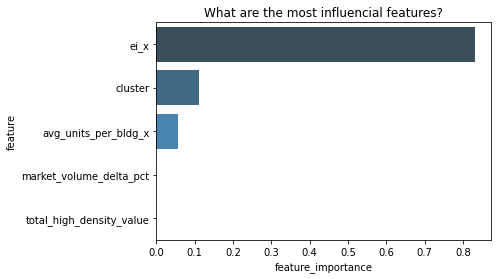

In [101]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

Interestingly, it seems that when it comes to decision tree, the `evolution_index` is actually the most indicative feature, along side the change in number of mortgage's approved. It appears that `market_volume_delta_pct` and `total_high_density_value` are actually not that useful for decision tree.

# Random Forest

In [102]:
for i in range(1, 20):
    rf, y_pred = model.run_rf(train_scaled, y_train, 1, i)
    score = rf.score(train_scaled, y_train)
    validate_score = rf.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(rf, y_pred, y_train)
    recall_score = report[recall_value].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

Max_depth = 1, accuracy_score = 0.77. validate_score = 0.79, recall = 0.13
Max_depth = 2, accuracy_score = 0.85. validate_score = 0.82, recall = 0.76
Max_depth = 3, accuracy_score = 0.86. validate_score = 0.82, recall = 0.81
Max_depth = 4, accuracy_score = 0.88. validate_score = 0.84, recall = 0.87
Max_depth = 5, accuracy_score = 0.89. validate_score = 0.84, recall = 0.91
Max_depth = 6, accuracy_score = 0.92. validate_score = 0.85, recall = 0.94
Max_depth = 7, accuracy_score = 0.95. validate_score = 0.87, recall = 0.97
Max_depth = 8, accuracy_score = 0.97. validate_score = 0.89, recall = 0.99
Max_depth = 9, accuracy_score = 0.98. validate_score = 0.89, recall = 0.99
Max_depth = 10, accuracy_score = 0.99. validate_score = 0.90, recall = 1.00
Max_depth = 11, accuracy_score = 1.00. validate_score = 0.91, recall = 1.00
Max_depth = 12, accuracy_score = 1.00. validate_score = 0.92, recall = 1.00
Max_depth = 13, accuracy_score = 1.00. validate_score = 0.92, recall = 1.00
Max_depth = 14, accur

In [103]:
rf, y_pred = model.run_rf(train_scaled, y_train, 1, 3)
predictions["random_forest"] = y_pred

In [104]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.86
       False  True 
False   1192    157
True      87    361


,False,True,accuracy,macro avg,weighted avg
precision,0.931978,0.696911,0.864218,0.814445,0.873375
recall,0.883617,0.805804,0.864218,0.844711,0.864218
f1-score,0.907154,0.747412,0.864218,0.827283,0.867329
support,1349.000000,448.000000,0.864218,1797.000000,1797.000000


In [105]:
coef = rf.feature_importances_
columns = train_scaled.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

Text(0.5, 1.0, 'What are the most influencial features?')

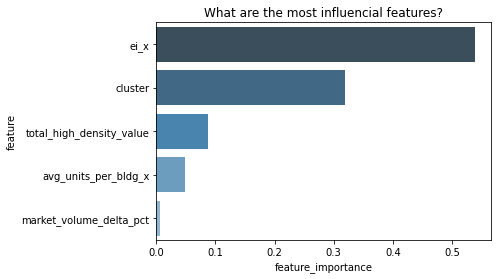

In [106]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

Similarly, for random forest, the `evolution_index` is the most influencial feature, along with the clusters. 

# KNN

In [107]:
for i in range(1, 20):
    knn, y_pred = model.run_knn(train_scaled, y_train, i)
    score = knn.score(train_scaled, y_train)
    validate_score = knn.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(knn, y_pred, y_train)
    recall_score = report[recall_value].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

Max_depth = 1, accuracy_score = 1.00. validate_score = 0.92, recall = 1.00
Max_depth = 2, accuracy_score = 0.99. validate_score = 0.88, recall = 0.95
Max_depth = 3, accuracy_score = 0.94. validate_score = 0.86, recall = 0.97
Max_depth = 4, accuracy_score = 0.92. validate_score = 0.83, recall = 0.85
Max_depth = 5, accuracy_score = 0.91. validate_score = 0.83, recall = 0.91
Max_depth = 6, accuracy_score = 0.89. validate_score = 0.83, recall = 0.77
Max_depth = 7, accuracy_score = 0.89. validate_score = 0.85, recall = 0.86
Max_depth = 8, accuracy_score = 0.89. validate_score = 0.84, recall = 0.81
Max_depth = 9, accuracy_score = 0.88. validate_score = 0.84, recall = 0.87
Max_depth = 10, accuracy_score = 0.89. validate_score = 0.84, recall = 0.83
Max_depth = 11, accuracy_score = 0.88. validate_score = 0.85, recall = 0.86
Max_depth = 12, accuracy_score = 0.88. validate_score = 0.84, recall = 0.81
Max_depth = 13, accuracy_score = 0.87. validate_score = 0.84, recall = 0.84
Max_depth = 14, accur

In [108]:
knn, y_pred = model.run_knn(train_scaled, y_train, 2)
predictions["knn"] = y_pred

In [109]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.99
       False  True 
False   1349      0
True      22    426


,False,True,accuracy,macro avg,weighted avg
precision,0.983953,1.000000,0.987757,0.991977,0.987954
recall,1.000000,0.950893,0.987757,0.975446,0.987757
f1-score,0.991912,0.974828,0.987757,0.983370,0.987653
support,1349.000000,448.000000,0.987757,1797.000000,1797.000000


In [110]:
# How do the different models compare on accuracy?
print("Accuracy Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report.accuracy[0]:.2f}')

Accuracy Scores
---------------
Actual = 1.00
Baseline = 0.75
Decision_Tree = 0.84
Random_Forest = 0.86
Knn = 0.99


In [111]:
# How do the different models compare on recall?
print("Recall Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report[recall_value].loc["recall"]:.2f}')

Recall Scores
---------------
Actual = 1.00
Baseline = 0.00
Decision_Tree = 0.68
Random_Forest = 0.81
Knn = 0.95


In [112]:
# How do the different models compare on recall?
print("Precision Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report[recall_value].loc["precision"]:.2f}')

Precision Scores
---------------
Actual = 1.00
Baseline = 0.00
Decision_Tree = 0.68
Random_Forest = 0.70
Knn = 1.00


# Evaluate

The best performing model is the KNN. It certainly performs better than the rest of the models, and much better than the baseline, meaning that in this case we definitively recommend using a model.

We will evaluate the KNN model with a `K_neighbore` of 1.

In [113]:
knn, y_pred = model.run_knn(train_scaled, y_train, 1)

In [114]:
y_pred = knn.predict(test_scaled)

In [115]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_test)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.91
       False  True 
False    547     54
True      15    184


,False,True,accuracy,macro avg,weighted avg
precision,0.973310,0.773109,0.91375,0.873209,0.923510
recall,0.910150,0.924623,0.91375,0.917386,0.913750
f1-score,0.940671,0.842105,0.91375,0.891388,0.916153
support,601.000000,199.000000,0.91375,800.000000,800.000000


## Conclusion:

We see that KNN achieves a 91% accuracy and a 92% recall_score on test data. This is a really strong model, and we have confidence that we can use it to predict markets that Testfit should enter in 2020 and 2021, given that they are likely going to increase in value over the next two years. 

In the end, we do reject our null hypothesis, and can confidently say that `Evolution_index`, `avg_units_per_building`, `market_volume_growth` and `total_high_density_value` are good features to use for modeling, as they can help us understand and evaluate how a city might be peforming, especially in comparison to the rest of the country. The clusters have also been invaluable, as not only did they helped create our labels, but they also provide valuable information when it comes to modeling.

----

# Prediction

As part of our deliverables, it is important for our stakeholder that we can come up with a series of recommendations on which markets they should enter in 2020 and 2021. Because of Testfit's business model, they realistically need to enter a market 2 or 3 years before the market actually picks up, as their software is most useful when companies are in the planning stages and trying to secure loans. As such, we need to predict not what market's will be hot in 2020, but rather predict what markets will be hot in 2022 or 2023. 

We will average the data from 2018 and 2019 to create values for 2020 and 2021. Using the K-means cluster we fitted during the exploration, we can create a new cluster prediction on the aggregated values, which we can use for modeling. 

Once the data is scaled and clustered, we can use our KNN model to create a prediction on which cities will be Testgit should enter in 2020 and 2021.

In [116]:
df = permits_preprocessing_mother_function()

In [117]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.cluster import KMeans

In [118]:
df = df[df.year > 1997]

In [119]:
# create object
scaler = PowerTransformer()
# fit object
scaler.fit(df[["avg_units_per_bldg"]])
# transform using object
df["avg_units_per_bldg_scaled"] = scaler.transform(df[["avg_units_per_bldg"]])

scaler.fit(df[["ei"]])
# transform using object
df["ei_scaled"] = scaler.transform(df[["ei"]])

In [120]:
# df = df.dropna()

In [121]:
# define features for KMeans modeling
X = df[["avg_units_per_bldg_scaled", "ei_scaled"]]

# cluster using k of 6

# create object
kmeans = KMeans(n_clusters=6, random_state=123)
# fit object
kmeans.fit(X)
# predict using object
df["cluster"] = kmeans.predict(X)

In [122]:
features_for_predicting = ["ei_x", "avg_units_per_bldg_x", "cluster", ]

In [123]:
df = df.merge(centroids, how="left", left_on="cluster", right_on=centroids.index)

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2860 entries, 0 to 2859
Data columns (total 26 columns):
city                                       2860 non-null object
state                                      2860 non-null object
year                                       2860 non-null int64
total_high_density_bldgs                   2860 non-null float64
total_high_density_units                   2860 non-null float64
total_high_density_value                   2860 non-null float64
avg_units_per_bldg_x                       2860 non-null float64
value_per_bldg                             2860 non-null float64
value_per_unit                             2860 non-null float64
city_state_high_density_bldgs_delta_pct    2860 non-null float64
city_state_high_density_units_delta_pct    2860 non-null float64
city_state_high_density_value_delta_pct    2860 non-null float64
market_volume                              2860 non-null float64
market_volume_delta_pct                    2860 non-

In [125]:
predictions = df[(df.year == 2018) | (df.year == 2019)].groupby("city_state")[["avg_units_per_bldg_scaled", "ei_scaled", "avg_units_per_bldg_x", "ei_x", "market_volume_delta_pct", "total_high_density_value"]].mean()

In [126]:
# define features for KMeans modeling
X = predictions[["avg_units_per_bldg_scaled", "ei_scaled"]]

predictions["cluster"] = kmeans.predict(X)

In [127]:
predictions

,avg_units_per_bldg_scaled,ei_scaled,avg_units_per_bldg_x,ei_x,market_volume_delta_pct,total_high_density_value,cluster
city_state,,,,,,,
Albany_NY,-0.147052,-0.334305,15.854167,1.202852,0.075357,1.376360e+08,0
Albuquerque_NM,-1.050007,-0.021614,12.241758,2.948283,0.075357,1.339200e+07,5
Allentown_PA,-0.489048,0.584361,13.260181,1.523173,0.075357,1.891200e+07,5
Anchorage_AK,-1.006631,-0.040374,10.313636,0.973912,0.075357,3.302250e+07,5
Appleton_WI,0.255819,-1.000871,22.500000,0.503518,0.075357,8.524000e+06,0
...,...,...,...,...,...,...,...
Tuscaloosa_AL,0.983117,0.561916,33.672360,1.494644,0.075357,1.024580e+08,3
Washington_DC,2.275218,0.143312,66.694644,1.110245,0.075357,1.578462e+09,3
Wilmington_NC,0.964055,0.545141,29.046875,1.606273,0.075357,1.341095e+08,3


In [128]:
predictions.drop(columns=["avg_units_per_bldg_scaled", "ei_scaled"], inplace=True)

In [129]:
# Helper function used to updated the scaled arrays and transform them into usable dataframes
def return_values_prediction(scaler, df):
    train_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns.values).set_index([df.index.values])
    return scaler, train_scaled

# Linear scaler
def min_max_scaler_prediction(df):
    scaler = MinMaxScaler().fit(df)
    scaler, df_scaled = return_values_prediction(scaler, df)
    return scaler, df_scaled

In [130]:
scaler, predictions_scaled = min_max_scaler_prediction(predictions)

In [131]:
predictions["label"] = knn.predict(predictions_scaled)

In [132]:
predictions

,avg_units_per_bldg_x,ei_x,market_volume_delta_pct,total_high_density_value,cluster,label
city_state,,,,,,
Albany_NY,15.854167,1.202852,0.075357,1.376360e+08,0,True
Albuquerque_NM,12.241758,2.948283,0.075357,1.339200e+07,5,True
Allentown_PA,13.260181,1.523173,0.075357,1.891200e+07,5,True
Anchorage_AK,10.313636,0.973912,0.075357,3.302250e+07,5,True
Appleton_WI,22.500000,0.503518,0.075357,8.524000e+06,0,True
...,...,...,...,...,...,...
Tuscaloosa_AL,33.672360,1.494644,0.075357,1.024580e+08,3,False
Washington_DC,66.694644,1.110245,0.075357,1.578462e+09,3,False
Wilmington_NC,29.046875,1.606273,0.075357,1.341095e+08,3,True


In [133]:
city = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[0]

state = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[1]

In [134]:
predictions = predictions.reset_index()

In [135]:
predictions["city"] = city

predictions["state"] = state

In [136]:
predictions

,city_state,avg_units_per_bldg_x,ei_x,market_volume_delta_pct,total_high_density_value,cluster,label,city,state
0,Albany_NY,15.854167,1.202852,0.075357,1.376360e+08,0,True,Albany,NY
1,Albuquerque_NM,12.241758,2.948283,0.075357,1.339200e+07,5,True,Albuquerque,NM
2,Allentown_PA,13.260181,1.523173,0.075357,1.891200e+07,5,True,Allentown,PA
3,Anchorage_AK,10.313636,0.973912,0.075357,3.302250e+07,5,True,Anchorage,AK
4,Appleton_WI,22.500000,0.503518,0.075357,8.524000e+06,0,True,Appleton,WI
...,...,...,...,...,...,...,...,...,...
125,Tuscaloosa_AL,33.672360,1.494644,0.075357,1.024580e+08,3,False,Tuscaloosa,AL
126,Washington_DC,66.694644,1.110245,0.075357,1.578462e+09,3,False,Washington,DC
127,Wilmington_NC,29.046875,1.606273,0.075357,1.341095e+08,3,True,Wilmington,NC
128,Worcester_MA,31.277778,1.467458,0.075357,5.974800e+07,3,False,Worcester,MA


In [137]:
predictions[predictions.label == True].shape[0] / predictions.shape[0]

0.6307692307692307

In [138]:
print(predictions[predictions.label].shape[0])
predictions[predictions.label]

82


,city_state,avg_units_per_bldg_x,ei_x,market_volume_delta_pct,total_high_density_value,cluster,label,city,state
0,Albany_NY,15.854167,1.202852,0.075357,137636000.0,0,True,Albany,NY
1,Albuquerque_NM,12.241758,2.948283,0.075357,13392000.0,5,True,Albuquerque,NM
2,Allentown_PA,13.260181,1.523173,0.075357,18912000.0,5,True,Allentown,PA
3,Anchorage_AK,10.313636,0.973912,0.075357,33022500.0,5,True,Anchorage,AK
4,Appleton_WI,22.500000,0.503518,0.075357,8524000.0,0,True,Appleton,WI
...,...,...,...,...,...,...,...,...,...
122,Trenton_NJ,12.031897,0.757433,0.075357,15871000.0,5,True,Trenton,NJ
123,Tucson_AZ,17.727857,0.675233,0.075357,140406000.0,0,True,Tucson,AZ
124,Tulsa_OK,26.064560,1.539774,0.075357,82830000.0,2,True,Tulsa,OK
127,Wilmington_NC,29.046875,1.606273,0.075357,134109500.0,3,True,Wilmington,NC


In [139]:
# predictions.to_csv("predictions.csv")

In [140]:
predictions

,city_state,avg_units_per_bldg_x,ei_x,market_volume_delta_pct,total_high_density_value,cluster,label,city,state
0,Albany_NY,15.854167,1.202852,0.075357,1.376360e+08,0,True,Albany,NY
1,Albuquerque_NM,12.241758,2.948283,0.075357,1.339200e+07,5,True,Albuquerque,NM
2,Allentown_PA,13.260181,1.523173,0.075357,1.891200e+07,5,True,Allentown,PA
3,Anchorage_AK,10.313636,0.973912,0.075357,3.302250e+07,5,True,Anchorage,AK
4,Appleton_WI,22.500000,0.503518,0.075357,8.524000e+06,0,True,Appleton,WI
...,...,...,...,...,...,...,...,...,...
125,Tuscaloosa_AL,33.672360,1.494644,0.075357,1.024580e+08,3,False,Tuscaloosa,AL
126,Washington_DC,66.694644,1.110245,0.075357,1.578462e+09,3,False,Washington,DC
127,Wilmington_NC,29.046875,1.606273,0.075357,1.341095e+08,3,True,Wilmington,NC
128,Worcester_MA,31.277778,1.467458,0.075357,5.974800e+07,3,False,Worcester,MA


In [141]:
predictions[(predictions.label) & ((predictions.cluster == 0) | (predictions.cluster == 4))].city_state.values

array(['Albany_NY', 'Appleton_WI', 'Charleston_SC', 'Charlottesville_VA',
       'Columbus_OH', 'El Paso_TX', 'Florence_AL', 'Greensboro_NC',
       'Naples_FL', 'Sioux Falls_SD', 'Spokane_WA', 'Syracuse_NY',
       'Tucson_AZ'], dtype=object)

In [142]:
df_best = (
    predictions[(predictions.label) & ((predictions.cluster == 0) | (predictions.cluster == 4))]
)

df_high_density = (
    predictions[(predictions.label) & ((predictions.cluster == 5) | (predictions.cluster == 2))]


)

df_stable_high_markets = (
    predictions[(predictions.label) & ((predictions.cluster == 3) | (predictions.cluster == 1))]


)

In [143]:
df_best["recommendation_label"] = "Best_ROI"

In [144]:
df_high_density["recommendation_label"] = "medium_ROI"

In [145]:
df_stable_high_markets["recommendation_label"] = "Stable_High"

In [146]:
predictions["recommendation_label"] = np.nan

In [147]:
predictions.recommendation_label = predictions.recommendation_label.fillna(df_best.recommendation_label)

In [148]:
predictions.recommendation_label = predictions.recommendation_label.fillna(df_high_density.recommendation_label)

In [149]:
predictions.recommendation_label = predictions.recommendation_label.fillna(df_stable_high_markets.recommendation_label)

In [150]:
predictions.recommendation_label = predictions.recommendation_label.fillna("Not Recommended to Enter")

In [151]:
predictions.recommendation_label.value_counts()

High_Density                58
Not Recommended to Enter    48
Best_ROI                    13
Stable_High                 11
Name: recommendation_label, dtype: int64

In [152]:
print("Markets with greatest return on investment")
print("-------------------")
print(predictions[(predictions.label) & ((predictions.cluster == 0) | (predictions.cluster == 4))].city_state.to_string(index=False))

print("")
print("High density markets with potential for growth")
print("------------------")
print(predictions[(predictions.label) & ((predictions.cluster == 5) | (predictions.cluster == 2))].city_state.to_string(index=False))

print("")
print("Markets already hot")
print("------------------")
print(predictions[(predictions.label) & ((predictions.cluster == 3) | (predictions.cluster == 1))].city_state.to_string(index=False))

Markets with greatest return on investment
-------------------
          Albany_NY
        Appleton_WI
      Charleston_SC
 Charlottesville_VA
        Columbus_OH
         El Paso_TX
        Florence_AL
      Greensboro_NC
          Naples_FL
     Sioux Falls_SD
         Spokane_WA
        Syracuse_NY
          Tucson_AZ

High density markets with potential for growth
------------------
      Albuquerque_NM
        Allentown_PA
        Anchorage_AK
       Bellingham_WA
       Birmingham_AL
      Bloomington_IL
       Boise City_ID
          Boulder_CO
      Brownsville_TX
          Buffalo_NY
           Canton_OH
      Chattanooga_TN
      Clarksville_TN
        Cleveland_OH
 Colorado Springs_CO
         Columbia_SC
         Columbus_GA
        Davenport_IA
          Detroit_MI
       Eau Claire_WI
             Erie_PA
       Evansville_IN
     Fayetteville_AR
     Fort Collins_CO
       Fort Wayne_IN
           Fresno_CA
          Greeley_CO
        Green Bay_WI
       Greenville_SC
 

In [153]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 10 columns):
city_state                  130 non-null object
avg_units_per_bldg_x        130 non-null float64
ei_x                        130 non-null float64
market_volume_delta_pct     130 non-null float64
total_high_density_value    130 non-null float64
cluster                     130 non-null int32
label                       130 non-null bool
city                        130 non-null object
state                       130 non-null object
recommendation_label        130 non-null object
dtypes: bool(1), float64(4), int32(1), object(4)
memory usage: 8.9+ KB


In [154]:
predictions.groupby("recommendation_label").total_high_density_value.mean()

recommendation_label
Best_ROI                    1.153248e+08
High_Density                8.867074e+07
Not Recommended to Enter    6.841568e+08
Stable_High                 9.722252e+08
Name: total_high_density_value, dtype: float64

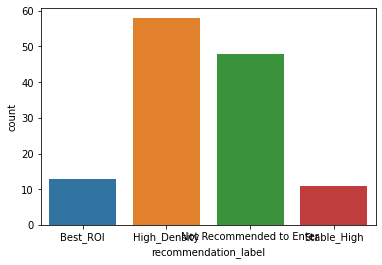

In [171]:

sns.countplot(data=predictions, x="recommendation_label")

In [155]:
high = df[(df.cluster == 1) | (df.cluster == 3)].total_high_density_value.mean()

In [156]:
print(f"${high:,.0f}")

$432,655,465


In [157]:
low = df[(df.cluster == 0) | (df.cluster == 4)].total_high_density_value.mean()

In [158]:
print(f"${low:,.0f}")

$99,833,469


In [159]:
medium = df[(df.cluster == 2) | (df.cluster == 5)].total_high_density_value.mean()

In [160]:
print(f"${medium:,.0f}")

$162,594,820


In [161]:
print(f"We expect emergig markets to increase, on average, by {(high - low) / low:.0%} over the next two years")

We expect emergig markets to increase, on average, by 333% over the next two years


In [162]:
print(f"We expect medium markets to increase their investment, on average, by {(high - medium) / medium:.0%}")

We expect medium markets to increase their investment, on average, by 166%


In [163]:
print(f"We expect declining markets to decrease their investment, on average, by {(low - high) / high:.0%}")

We expect declining markets to decrease their investment, on average, by -77%


In [164]:
print(f"We expect emergig markets to increase, on average, by ${(high - low):,.0f} over the next two years")

We expect emergig markets to increase, on average, by $332,821,996 over the next two years


In [165]:
print(f"We expect medium markets to increase their investment, on average, by {(high - medium):,.0f}")

We expect medium markets to increase their investment, on average, by 270,060,645


In [166]:
print(f"We expect declining markets to decrease their investment, on average, by {(low - high):,.0f}")

We expect declining markets to decrease their investment, on average, by -332,821,996
